In [94]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))
print("Memory (MB):", torch.cuda.get_device_properties(0).total_memory / 1e6)



Torch version: 2.5.1+cu121
CUDA available: True
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU
Memory (MB): 6438.780928


In [95]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn, optim
import random



In [96]:
#setting seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [97]:
# Load the dataset
data_path = r"D:\Projects\music_genre_classification\music_genre_classification\data\features_3_sec.csv"
df = pd.read_csv(data_path)

# Display basic information about the dataset
print("Information about the Data:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())


Information about the Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 

In [98]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())
#drop missing values
df.dropna()


Missing Values:
filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [99]:
# Check for missing values
print(df.isnull().sum().sort_values(ascending=False))

# Check basic info
df.info()


filename                   0
length                     0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var                  0
mfcc9_mean                 0
mfcc9_var                  0
mfcc10_mean                0
mfcc10_var                 0
mfcc11_mean                0
mfcc11_var                 0
mfcc12_mean                0
mfcc12_var                 0
mfcc13_mean                0
mfcc13_var                 0
mfcc14_mean                0
mfcc14_var                 0
mfcc15_mean                0
mfcc15_var                 0
mfcc16_mean                0
mfcc16_var                 0
mfcc17_mean                0
mfcc17_var                 0
mfcc18_mean                0
mfcc18_var                 0
mfcc19_mean                0
mfcc19_var                 0
mfcc20_mean                0
mfcc20_var                 0
mfcc7_mean                 0
mfcc6_var                  0
mfcc6_mean                 0
harmony_mean               0
chroma_stft_mean           0
chroma_stft_va

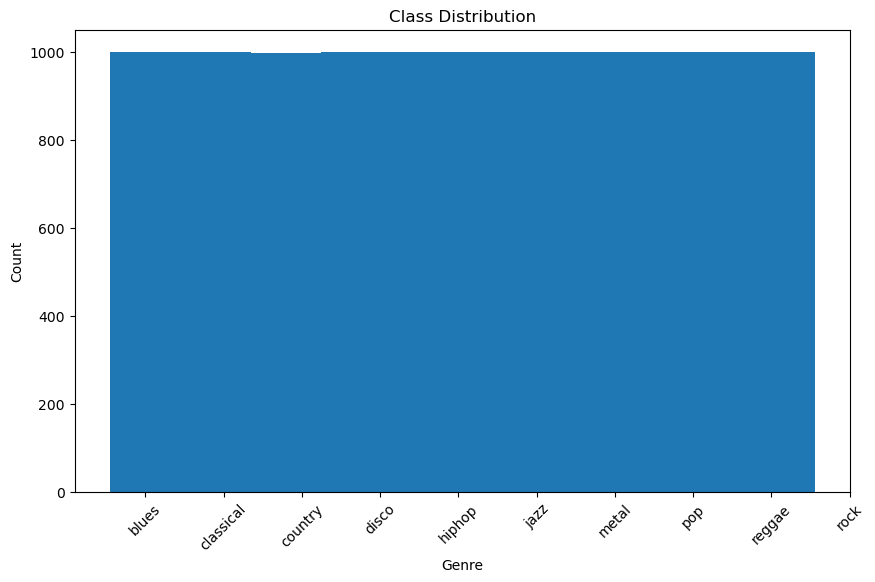

In [100]:
# Extract features and labels
X = df.drop(columns=['filename', 'label'])
y = df['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.hist(y_encoded, bins=len(label_encoder.classes_), align='left')
plt.xticks(range(len(label_encoder.classes_)), label_encoder.classes_, rotation=45)
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

In [101]:
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=2025, stratify=y_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=2025, stratify=y_temp
)

# Print dataset sizes
print(f"\nTrain set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Train set size: 6993
Validation set size: 1498
Test set size: 1499


In [102]:
# Save processed data for reuse in other notebooks

joblib.dump((X_train, y_train), r"D:\Projects\DL_gtzan\data\preprocessed_data\train_data.pkl")
joblib.dump((X_val, y_val), r"D:\Projects\DL_gtzan\data\preprocessed_data\val_data.pkl")
joblib.dump((X_test, y_test), r"D:\Projects\DL_gtzan\data\preprocessed_data\test_data.pkl")

print("Processed data saved successfully!")

Processed data saved successfully!


In [103]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save label encoder
joblib.dump(label_encoder, r"D:\Projects\DL_gtzan\data\preprocessed_data\label_encoder.pkl")

['D:\\Projects\\DL_gtzan\\data\\preprocessed_data\\label_encoder.pkl']

In [104]:
# Load original unscaled data
X_train, y_train = joblib.load(r"D:\Projects\DL_gtzan\data\preprocessed_data\train_data.pkl")
X_val, y_val     = joblib.load(r"D:\Projects\DL_gtzan\data\preprocessed_data\val_data.pkl")
X_test, y_test   = joblib.load(r"D:\Projects\DL_gtzan\data\preprocessed_data\test_data.pkl")

# Initialize and fit scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Ensure float32 dtype for deep learning
X_train_scaled = X_train_scaled.astype(np.float32)
X_val_scaled   = X_val_scaled.astype(np.float32)
X_test_scaled  = X_test_scaled.astype(np.float32)

# Save scaled data
joblib.dump((X_train_scaled, y_train), r"D:\Projects\DL_gtzan\data\preprocessed_data\train_data_scaled.pkl")
joblib.dump((X_val_scaled, y_val),     r"D:\Projects\DL_gtzan\data\preprocessed_data\val_data_scaled.pkl")
joblib.dump((X_test_scaled, y_test),   r"D:\Projects\DL_gtzan\data\preprocessed_data\test_data_scaled.pkl")

# Save the scaler for reuse in inference or other notebooks
joblib.dump(scaler, r"D:\Projects\DL_gtzan\data\preprocessed_datascaler.pkl")

print("Data successfully scaled and saved.")


Data successfully scaled and saved.


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'blues'),
  Text(1, 0, 'classical'),
  Text(2, 0, 'country'),
  Text(3, 0, 'disco'),
  Text(4, 0, 'hiphop'),
  Text(5, 0, 'jazz'),
  Text(6, 0, 'metal'),
  Text(7, 0, 'pop'),
  Text(8, 0, 'reggae'),
  Text(9, 0, 'rock')])

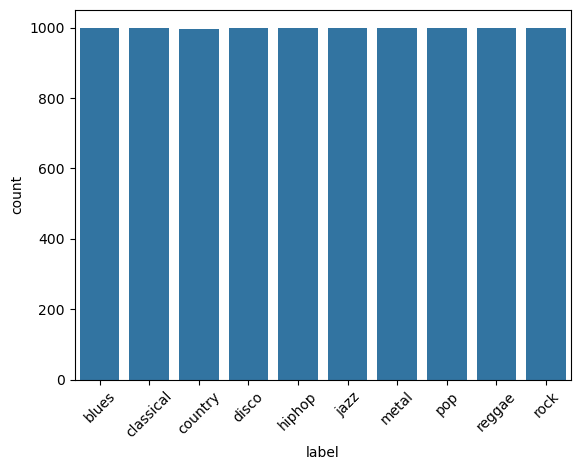

In [105]:
#Checking the Distribution of data per genre
import seaborn as sns
sns.countplot(x=y, order=label_encoder.classes_)
plt.xticks(rotation=45)


In [106]:
#Dataset loader class
class genreDataloader(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def get_dataloaders(data_dir, batch_size=64, shuffle=True):
    # Load scaled data
    train_data = joblib.load(f"{data_dir}/train_data_scaled.pkl")
    val_data   = joblib.load(f"{data_dir}/val_data_scaled.pkl")
    test_data  = joblib.load(f"{data_dir}/test_data_scaled.pkl")

    # Create genreDataloader instances
    train_set = genreDataloader(*train_data)
    val_set   = genreDataloader(*val_data)
    test_set  = genreDataloader(*test_data)

    # Wrap in DataLoaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
    val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [107]:
#initialising the base MLP
class BaseMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128], num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dims[1], num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [108]:
#Training Loop
def train_loop(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_correct = 0, 0
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        total_correct += (pred.argmax(1) == yb).sum().item()
    return total_loss / len(dataloader.dataset), total_correct / len(dataloader.dataset)

# Evaluation loop
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_loss += loss.item() * xb.size(0)
            total_correct += (pred.argmax(1) == yb).sum().item()
    return total_loss / len(dataloader.dataset), total_correct / len(dataloader.dataset)


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# Prepare data
data_dir = r"D:\Projects\DL_gtzan\data\preprocessed_data"

train_loader, val_loader, test_loader = get_dataloaders(data_dir, batch_size=128)
input_size = next(iter(train_loader))[0].shape[1]

# Initialize model
model = BaseMLP(input_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
epochs = 100
for epoch in range(epochs):
    train_loss, train_acc = train_loop(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)


Epoch 1/100 | Train Acc: 0.4753 | Val Acc: 0.6121
Epoch 2/100 | Train Acc: 0.6489 | Val Acc: 0.7043
Epoch 3/100 | Train Acc: 0.6948 | Val Acc: 0.7383
Epoch 4/100 | Train Acc: 0.7257 | Val Acc: 0.7623
Epoch 5/100 | Train Acc: 0.7473 | Val Acc: 0.7777
Epoch 6/100 | Train Acc: 0.7568 | Val Acc: 0.7891
Epoch 7/100 | Train Acc: 0.7769 | Val Acc: 0.8071
Epoch 8/100 | Train Acc: 0.7898 | Val Acc: 0.8131
Epoch 9/100 | Train Acc: 0.7949 | Val Acc: 0.8057
Epoch 10/100 | Train Acc: 0.8045 | Val Acc: 0.8298
Epoch 11/100 | Train Acc: 0.8192 | Val Acc: 0.8284
Epoch 12/100 | Train Acc: 0.8215 | Val Acc: 0.8411
Epoch 13/100 | Train Acc: 0.8251 | Val Acc: 0.8364
Epoch 14/100 | Train Acc: 0.8323 | Val Acc: 0.8318
Epoch 15/100 | Train Acc: 0.8368 | Val Acc: 0.8431
Epoch 16/100 | Train Acc: 0.8418 | Val Acc: 0.8405
Epoch 17/100 | Train Acc: 0.8547 | Val Acc: 0.8531
Epoch 18/100 | Train Acc: 0.8580 | Val Acc: 0.8511
Epoch 19/100 | Train Acc: 0.8616 | Val Acc: 0.8525
Epoch 20/100 | Train Acc: 0.8663 | Val A

In [110]:
def evaluate_model_results(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = yb.numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n Accuracy: {acc:.4f}")
    print("\n Classification Report:")
    print(report)

    # Confusion Matrix Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()



 Accuracy: 0.9099

 Classification Report:
              precision    recall  f1-score   support

       blues     0.9000    0.9600    0.9290       150
   classical     0.8690    0.9733    0.9182       150
     country     0.9416    0.8658    0.9021       149
       disco     0.9000    0.9000    0.9000       150
      hiphop     0.9357    0.8733    0.9034       150
        jazz     0.9167    0.8800    0.8980       150
       metal     0.9653    0.9267    0.9456       150
         pop     0.9091    0.9333    0.9211       150
      reggae     0.9139    0.9200    0.9169       150
        rock     0.8609    0.8667    0.8638       150

    accuracy                         0.9099      1499
   macro avg     0.9112    0.9099    0.9098      1499
weighted avg     0.9112    0.9099    0.9098      1499



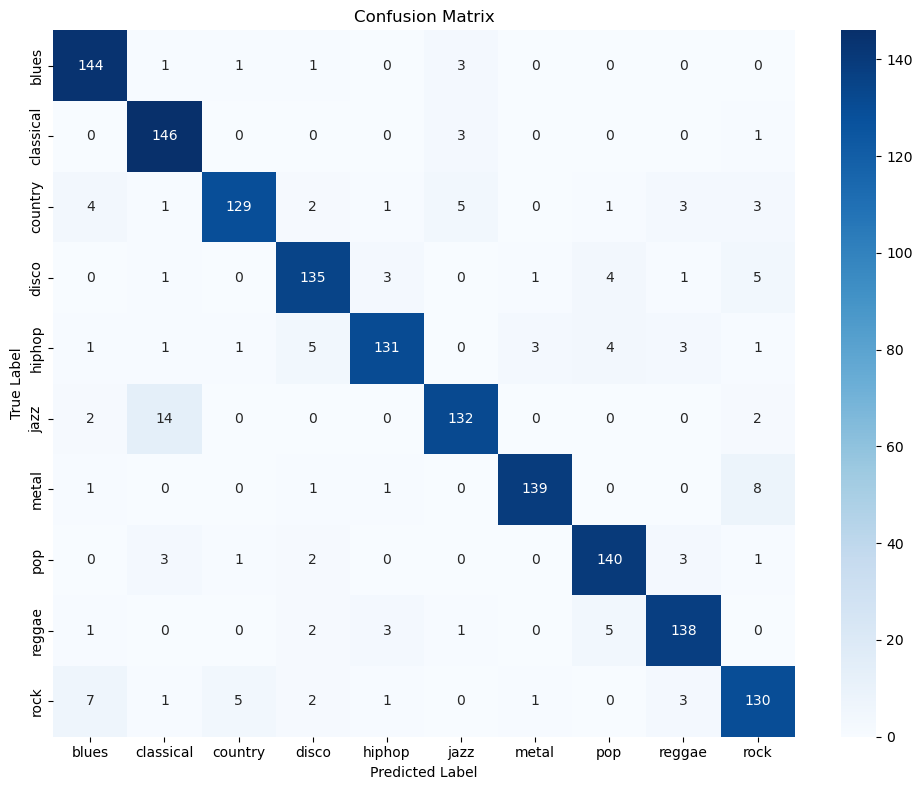

In [111]:
# Load label encoder used during preprocessing
label_encoder = joblib.load(r"D:\Projects\music_genre_classification\music_genre_classification\data\Processed_data\label_encoder.pkl")
class_names = list(label_encoder.classes_)

# Or manually define if not saved
# class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Run final test evaluation
evaluate_model_results(model, test_loader, class_names, device)


In [112]:
save_path = r"D:\Projects\DL_gtzan\models\Baseline_MLP\genre_mlp_weights.pth"
torch.save(model.state_dict(), save_path)


In [113]:
def evaluate_metrics(model, dataloader, device, class_names):
    """
    Runs the model on dataloader, prints classification report,
    and returns the confusion matrix.
    
    model:         trained torch.nn.Module
    dataloader:    DataLoader for the split you want to evaluate
    device:        torch.device('cuda' or 'cpu')
    class_names:   list of label names in order
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("=== Classification Report ===\n", report)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm

def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using Matplotlib.
    cm:           numpy array of shape (n_classes, n_classes)
    class_names:  list of label strings
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """
    history: dict with keys 'train_loss', 'val_loss', 'train_acc', 'val_acc'
             each mapping to a list of length num_epochs
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # Loss curves
    plt.figure()
    plt.plot(epochs, history['train_loss'])
    plt.plot(epochs, history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'])
    plt.title('Training vs. Validation Loss')
    plt.show()

    # Accuracy curves
    plt.figure()
    plt.plot(epochs, history['train_acc'])
    plt.plot(epochs, history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'])
    plt.title('Training vs. Validation Accuracy')
    plt.show()


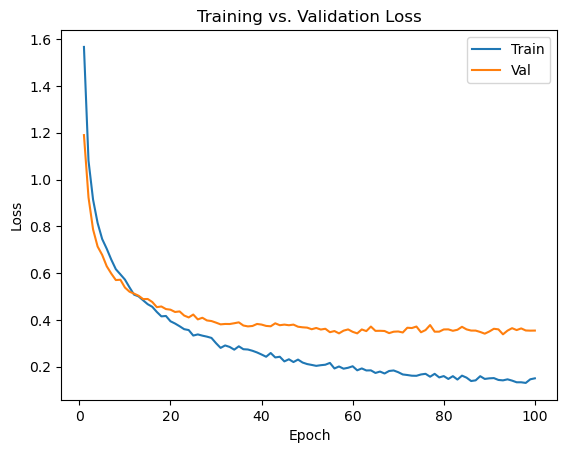

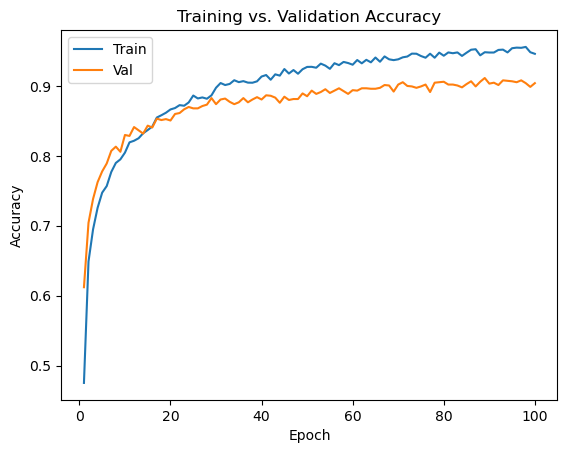

=== Classification Report ===
               precision    recall  f1-score   support

       blues       0.90      0.96      0.93       150
   classical       0.87      0.97      0.92       150
     country       0.94      0.87      0.90       149
       disco       0.90      0.90      0.90       150
      hiphop       0.94      0.87      0.90       150
        jazz       0.92      0.88      0.90       150
       metal       0.97      0.93      0.95       150
         pop       0.91      0.93      0.92       150
      reggae       0.91      0.92      0.92       150
        rock       0.86      0.87      0.86       150

    accuracy                           0.91      1499
   macro avg       0.91      0.91      0.91      1499
weighted avg       0.91      0.91      0.91      1499



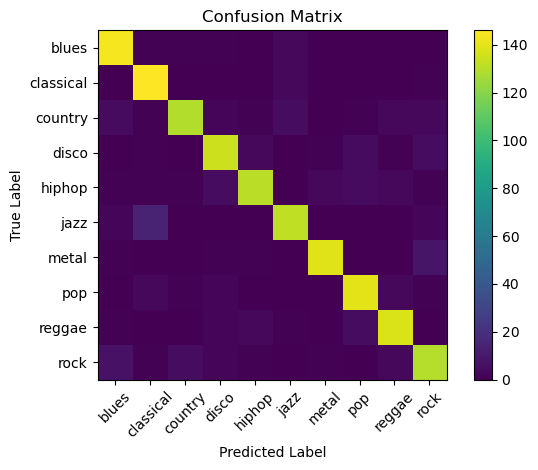

In [114]:
# 1) Plot loss & accuracy curves
plot_training_history(history)

# 2) Evaluate on test set & plot confusion matrix
cm = evaluate_metrics(model, test_loader, device, class_names)
plot_confusion_matrix(cm, class_names)
